In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold,train_test_split
import time
import math
root=''
try:
  from google.colab import drive
  drive.mount('/content/drive')
  root='./drive/MyDrive/gnn/data/'
except:
  pass
device='cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla T4


In [47]:
torch.cuda.empty_cache()

In [48]:
filename=root+'data_1354ac_2022/ieee1354_ISF.txt'
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename=root+'data_1354ac_2022/ieee1354_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit
print(S.shape,f_max.shape,torch.min(f_max))

x=np.load(root+'data_1354ac_2022/ac1354_x_04022022.npy')
y=np.load(root+'data_1354ac_2022/ac1354_y_04022022.npy')
W=np.load(root+'data_1354ac_2022/ac1354_w.npy')
print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))

# scaling on voltage
vy_deviation = 0.8
vy_scale = 1000
y[:,1,:] = (y[:,1,:] - vy_deviation) * vy_scale
print('voltage range(scaled):',np.min(y[:,1,:]),np.max(y[:,1,:]))

# scaling on price
pi_deviation = 150
y[:,0,:] = y[:,0,:] + pi_deviation


# filter out extreme points in price
y_sort_arg = np.argsort(np.amax(np.abs(y[:,0,:]),axis=0)) # max extreme
y_sort_arg1 = np.argsort(np.amin(y[:,0,:],axis=0),axis=0) # min extreme

del_idx0 = []
del_num = 500
for i in range(del_num):
  del_idx0.append(y_sort_arg[-i])
  del_idx0.append(y_sort_arg1[i])
print(del_idx0)
del_idx = [] # keep only non-repeated
[del_idx.append(x) for x in del_idx0 if x not in del_idx]
del_idx = np.sort(del_idx)
# delete extreme points
print('price range old:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range old:',np.min(y[:,1,:]),np.max(y[:,1,:]))
x = np.delete(x, del_idx, axis=2)
y = np.delete(y, del_idx, axis=2)

print('price range new:',np.min(y[:,0,:]),np.max(y[:,0,:]))
print('voltage range new:',np.min(y[:,1,:]),np.max(y[:,1,:]))

torch.Size([1991, 1354]) torch.Size([1991, 1]) tensor(281., device='cuda:0', dtype=torch.float64)
(1354, 6, 9974) (1354, 2, 9974)
5864.5 -2123.9 5178.4 -4855.3
voltage range(scaled): 99.99999999999997 333.89999999999986
[5202, 5331, 6839, 9322, 8889, 7576, 2333, 7126, 8493, 56, 8004, 8323, 7345, 4893, 2972, 932, 5720, 5228, 1179, 9099, 5331, 213, 7915, 2303, 3666, 8580, 8304, 5235, 1072, 4980, 4694, 549, 1666, 9749, 5898, 9527, 9657, 2436, 463, 6632, 5129, 1710, 4153, 1740, 106, 4845, 7424, 5418, 4923, 7202, 4413, 4027, 5959, 1240, 9776, 5788, 4961, 2089, 6513, 7990, 7508, 9501, 9562, 9639, 1746, 5246, 4179, 5013, 582, 3976, 3084, 9096, 7798, 5416, 3647, 1393, 9887, 9854, 861, 5709, 2089, 3223, 5803, 469, 359, 4940, 4341, 7348, 2071, 796, 2728, 7877, 4799, 8613, 8785, 8814, 6668, 6037, 420, 7507, 6516, 4756, 4029, 8483, 9794, 1898, 2121, 8944, 7573, 6260, 5132, 3225, 9622, 5127, 2913, 4759, 218, 6017, 16, 1967, 8427, 8351, 6316, 6342, 1844, 5909, 6343, 6424, 3648, 3683, 4012, 4952, 777

In [49]:
x_pre = x.copy()
y_pre = y.copy()
print(x.shape,y.shape)
n_sample = np.size(y_pre,2)
n_bus = np.size(y_pre,0)
print(n_sample)

(1354, 6, 9031) (1354, 2, 9031)
9031


In [50]:
## Reshape

# x=np.reshape(x,(x.shape[0],-1)) # reshape by samples not dim1
# y=np.reshape(y,(y.shape[0],-1))
x=np.reshape(x,(x.shape[0]*x.shape[1],x.shape[2])) # reshape by samples not dim1
y=np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))
print(x.shape)
print(y.shape)

# train val test split
# x_total,x_test,y_total,y_test=train_test_split(x,y,test_size=0.2,random_state=23)
x_total,x_test,y_total,y_test=train_test_split(x.transpose(),y.transpose(),test_size=0.2,random_state=23)
kf=KFold(n_splits=10,shuffle=True)
for train_index,val_index in kf.split(x_total):
  x_train=x_total[train_index]
  y_train=y_total[train_index]
  x_val=x_total[val_index]
  y_val=y_total[val_index]
  break
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

# data loader
class Dataset(torch.utils.data.Dataset):
    def __init__(self,x,y,device):
        self.x=torch.from_numpy(x).float().to(device)
        self.y=torch.from_numpy(y).float().to(device)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
          idx=idx.tolist()
        # Select sample
        return self.x[idx],self.y[idx]
params={'batch_size': 512,
        'shuffle': True,
        'num_workers': 0}
train=Dataset(x_train,y_train,device)
train_set=torch.utils.data.DataLoader(train,**params)
val=Dataset(x_val,y_val,device)
val_set=torch.utils.data.DataLoader(val,**params)


(8124, 9031)
(2708, 9031)
Training data size: (6501, 8124)
Training label size: (6501, 2708)


In [51]:
print(x.shape,y.shape,x_pre.shape,y_pre.shape)

(8124, 9031) (2708, 9031) (1354, 6, 9031) (1354, 2, 9031)


In [52]:
print(x[0,1:10])
print(x_pre[0,0,1:10])
print(x[0,1+1354:10+1354]) # reshape by samples, dim2
print(x[0,1+9031:10+9031])
print(x_pre[0,1,1:10])

[-159.86 -168.22 -167.97 -146.09 -173.21 -157.6  -165.26 -178.84 -135.31]
[-159.86 -168.22 -167.97 -146.09 -173.21 -157.6  -165.26 -178.84 -135.31]
[-135.1  -134.19 -171.36 -148.4  -168.66 -156.4  -167.36 -160.95 -179.98]
[]
[-159.86 -168.22 -167.97 -146.09 -173.21 -157.6  -165.26 -178.84 -135.31]


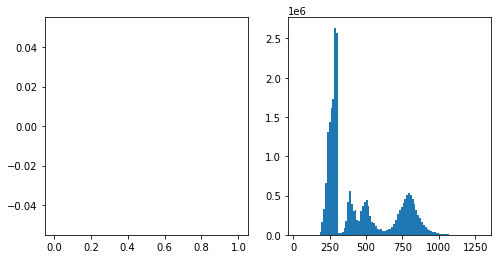

In [53]:
fig2 = plt.figure(figsize=(8,4))
flat_list = list(np.concatenate(y[:,n_sample:]).flat)
flat_list3 = list(np.concatenate(y[:,:n_sample]).flat)
plt.subplot(1,2,1)
plt.hist(flat_list,bins = 100,label = 'voltage')
plt.subplot(1,2,2)
# plt.hist(flat_list3,range=[-2000, 2000],bins = 100,label = 'price')
plt.hist(flat_list3,bins = 100,label = 'price')
plt.show()

In [54]:
class dnn(torch.nn.Module):
  def __init__(self,shape,dropout=0):
    super(dnn,self).__init__()
    layers=[]
    for idx in range(len(shape)-2):
      layers.extend([
        nn.Linear(shape[idx],shape[idx+1]),
        nn.ReLU(),
        nn.BatchNorm1d(shape[idx+1]),
        nn.Dropout(dropout)
      ])
    layers.append(nn.Linear(shape[-2],shape[-1]))
    self.features=nn.Sequential(*layers)
    # initialize
    for temp in self.features:
      if type(temp)==nn.Linear:
        torch.nn.init.normal_(temp.weight,mean=0,std=1)
  def forward(self,x):
    return self.features(x)

net=dnn([n_bus*6,n_bus*5,n_bus*2]).to(device)
# net=dnn([n_bus*6,n_bus*5,n_bus*5,n_bus*10,n_bus*10,n_bus*10,n_bus*10,n_bus*2]).to(device)

print('number of params: %d'%(sum(temp.numel() for temp in net.parameters() if temp.requires_grad)))

number of params: 73355658


In [55]:
# define loss function
loss_func=nn.MSELoss()


* Normalize the power of Laplacian

In [56]:
# load the pretrained parameters
# path=root+'./data_1354ac_2022/ac_v_S_feasgnn_0318.pickle'
# path=root+'data_1354ac_2022/gnn_trained_ac1354.pickle' # unregularized
# path=root+'data_1354ac_2022/feasgnn_trained_ac1354_04022022cold_unreg.pickle' # unregularized
# try: net.load_state_dict(torch.load(path))
# except: pass
try: 
  net.load_state_dict(torch.load(path))
  print('params loaded')
except: 
  print('cold start')
  pass



optimizer=torch.optim.Adam(net.parameters())
loss_optm=[]
val_loss=[]

## Training
t0=time.time()
max_epochs=20
eval_epoch=5

# earlystopping
tolerance=5
min_delta=1e-3
previous=0

for epoch in range(max_epochs):
  # training loop
  train_loss=0.0
  for local_batch,local_label in train_set:
    optimizer.zero_grad() # clear the past gradient
    # print(local_batch.shape,local_label.shape)
    logits=net(local_batch)
    loss=loss_func(logits,local_label)
    loss.backward()
    train_loss+=loss.item()
    optimizer.step() # update parameters of net
  loss_optm.append(train_loss/len(train_set.dataset))
  print("Epoch %d | Training loss: %.4f"%(epoch,train_loss/len(train_set.dataset)))
  # eval
  if (epoch+1)%eval_epoch==0:
    net.eval()
    eval_loss=0.0
    for local_batch,local_label in val_set:
      logits=net(local_batch)
      # loss=loss_func.calc(logits,local_label,local_batch)
      loss=loss_func(logits,local_label)
      eval_loss+=loss.item()
    eval_avg=eval_loss/len(val_set.dataset)
    if (epoch==0): previous=eval_avg
    else:
      if previous-eval_avg<min_delta: tolerance-=1
      if tolerance==0:
        # break
        pass
      previous=eval_avg
    print("Epoch %d | Eval loss: %.4f" % (epoch, eval_avg))
    val_loss.append([epoch, eval_loss/len(val_set.dataset)])
    net.train()
  # validation loop
  with torch.set_grad_enabled(False):
      pass
t1=time.time()
print("Training time:%.4fs"%(t1-t0))

cold start
Epoch 0 | Training loss: 514.2628
Epoch 1 | Training loss: 507.3604
Epoch 2 | Training loss: 496.0428
Epoch 3 | Training loss: 478.0376
Epoch 4 | Training loss: 452.3039
Epoch 4 | Eval loss: 12546.1511
Epoch 5 | Training loss: 418.6158
Epoch 6 | Training loss: 378.2466
Epoch 7 | Training loss: 333.3148
Epoch 8 | Training loss: 286.2620
Epoch 9 | Training loss: 239.8662
Epoch 9 | Eval loss: 992969.1176
Epoch 10 | Training loss: 196.6302
Epoch 11 | Training loss: 158.3619
Epoch 12 | Training loss: 125.8373
Epoch 13 | Training loss: 98.9488
Epoch 14 | Training loss: 77.0203
Epoch 14 | Eval loss: 2006391.7676
Epoch 15 | Training loss: 59.3111
Epoch 16 | Training loss: 45.0842
Epoch 17 | Training loss: 33.8251
Epoch 18 | Training loss: 25.0877
Epoch 19 | Training loss: 18.4444
Epoch 19 | Eval loss: 3805875.6957
Training time:16.7819s


In [57]:
# logits[0:2,:,:]
# W
path=root+'data_1354ac_2022/dnn_trained_ac1354_04022022cold_unreg.pickle'
# torch.save(net.state_dict(),path)

In [58]:
# print(len(loss_val))
# print(loss_val[0][0])
# # print(val_plt)
# print(logits.shape,eval_label.shape)

4


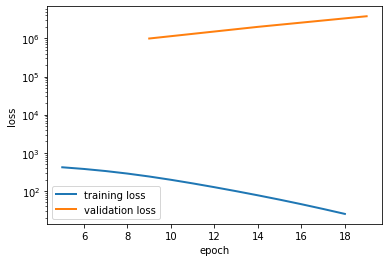

In [59]:
import matplotlib.pyplot as plt

val_len = len(val_loss)
print(val_len)
val_plt = np.zeros((2,val_len))
for i in range(val_len):
  val_plt[0,i] = val_loss[i][0]
  val_plt[1,i] = val_loss[i][1]

plt.figure()
plot_idx = np.arange(np.size(loss_optm))
# plt.plot(plot_idx,loss_optm,lw=2,label='training loss')
# plt.plot(val_plt[0,:],val_plt[1,:],lw=2,label='validation loss')
plt.plot(plot_idx[5:-1],loss_optm[5:-1],lw=2,label='training loss')
plt.plot(val_plt[0,1:],val_plt[1,1:],lw=2,label='validation loss')
plt.yscale("log")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show(block=False)

# from datetime import datetime
# now=datetime.now()
# timestamp=now.strftime('%Y%d%m%H%M%S')
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_%s.pickle'%(timestamp)
# # torch.save(net.state_dict(),path)
# path='/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_%s.pickle'%(timestamp)
# torch.save(net.state_dict(),path)
# path = '/content/drive/MyDrive/gnn/dnn_pytorch/gnn_118_20212205071835.pickle'
# net.load_state_dict(torch.load(path))
# path=root+'./data_1354ac_2022/ac_v_S_feasgnn_0318.pickle'
# torch.save(net.state_dict(),path)

# Evaluate the model w/ validation set

In [60]:
# local_batch, local_labels = local_batch.to(device), local_labels.to(device)
# print(local_batch.shape)
# x_test_feed = x_test_feed.unsqueeze_(-1).transpose(1,2)
# print(x_test_feed.shape)

# print(local_batch.shape)
# x_test.shape

In [61]:
# validation_set = Dataset(features=x_test, labels=y_test)
# validation_generator = torch.utils.data.DataLoader(validation_set, **params)
# for local_batch, local_labels in validation_generator:
#   # Transfer to GPU
#   local_batch, local_labels = local_batch.to(device), local_labels.to(device)
#   logits = net(local_batch)

# n_test = 2000
n_test = np.size(x_test,0)

# x_test_feed = torch.from_numpy(np.transpose(x_test)).float()
x_test_feed = torch.from_numpy(x_test).float()
x_test_feed = x_test_feed#.transpose(1,2)
x_test_feed = x_test_feed.to(device)
print('Validation dataset size:',x_test_feed.shape)
print('Number of validation set: ',n_test)
# y_pred = np.zeros((x_test_feed.shape))
# for i in range(n_test):
#   y_pred[i,:] = net(x_test_feed[i,:])
y_pred = net(x_test_feed)
print(y_pred.shape)

Validation dataset size: torch.Size([1807, 8124])
Number of validation set:  1807
torch.Size([1807, 2708])


* Visualization




 - Visualize errors

In [62]:
y_pred1 = y_pred.cpu().detach()
y_pred1 = torch.squeeze(y_pred1,1).numpy()#.transpose()
print(y_test.shape,y_pred1.shape)

(1807, 2708) (1807, 2708)


In [65]:
# x=np.reshape(x,(x.shape[0]*x.shape[1],x.shape[2])) # reshape by samples not dim1
# y=np.reshape(y,(y.shape[0]*y.shape[1],y.shape[2]))
# print(x_pre.shape,y_pre.shape)

y_pred_temp = y_pred1.copy().transpose()
# y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
y_pred2=np.zeros([y_pre.shape[0],y_pre.shape[1],n_test])
y_pred2[:,0,:]=y_pred_temp[:n_bus,:]
y_pred2[:,1,:]=y_pred_temp[n_bus:,:]
print(y_pred2.shape,y_pred1.shape)

y_test_temp = y_test.copy().transpose()
# y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
y_test2=np.zeros([y_pre.shape[0],y_pre.shape[1],n_test])
y_test2[:,0,:]=y_test_temp[:n_bus,:]
y_test2[:,1,:]=y_test_temp[n_bus:,:]

y_pred1 = y_pred2.copy()

# print(y_pred2[:10,0,0])
# print(y_pred1[0,:10])
# print(y_test[0,:10])

(1354, 2, 1807) (1807, 2708)


In [67]:
# recover the original p.u. scale
# vy_deviation) * vy_scale
y_pred1[:,1,:] = y_pred1[:,1,:] / vy_scale + vy_deviation
y_test2[:,1,:] = y_test2[:,1,:] / vy_scale + vy_deviation

print(y_test2.shape,y_pred1.shape)

(1354, 2, 1807) (1354, 2, 1807)


In [ ]:
# for i in range(5):
#   print('sample',i)
#   print(y_test[:,i])
#   print(y_pred1[:,i])

In [68]:
n_test = np.size(y_test2,2)
err_L2 = np.zeros(n_test)
err_Linf = np.zeros(n_test)
for i in range(n_test):
  err_L2[i] = np.linalg.norm(y_test2[:,0,i] - y_pred1[:,0,i]) / np.linalg.norm(y_test2[:,0,i])
  err_Linf[i] = np.max(np.abs(y_test2[:,0,i] - y_pred1[:,0,i])) / np.max(np.abs(y_test2[:,0,i]))

err_L2_v = np.zeros(n_test)
err_Linf_v = np.zeros(n_test)
for i in range(n_test):
  err_L2_v[i] = np.linalg.norm(y_test2[:,1,i] - y_pred1[:,1,i]) / np.linalg.norm(y_test2[:,1,i])
  err_Linf_v[i] = np.max(np.abs(y_test2[:,1,i] - y_pred1[:,1,i])) / np.max(np.abs(y_test2[:,1,i]))

In [69]:
print(err_L2.shape,err_Linf.shape)

(1807,) (1807,)


Price L2 mean: 0.17218456223625575 L_inf mean: 0.3641907824652842
Voltage L2 mean: 0.06979595522697234 L_inf mean: 0.19695008927483865


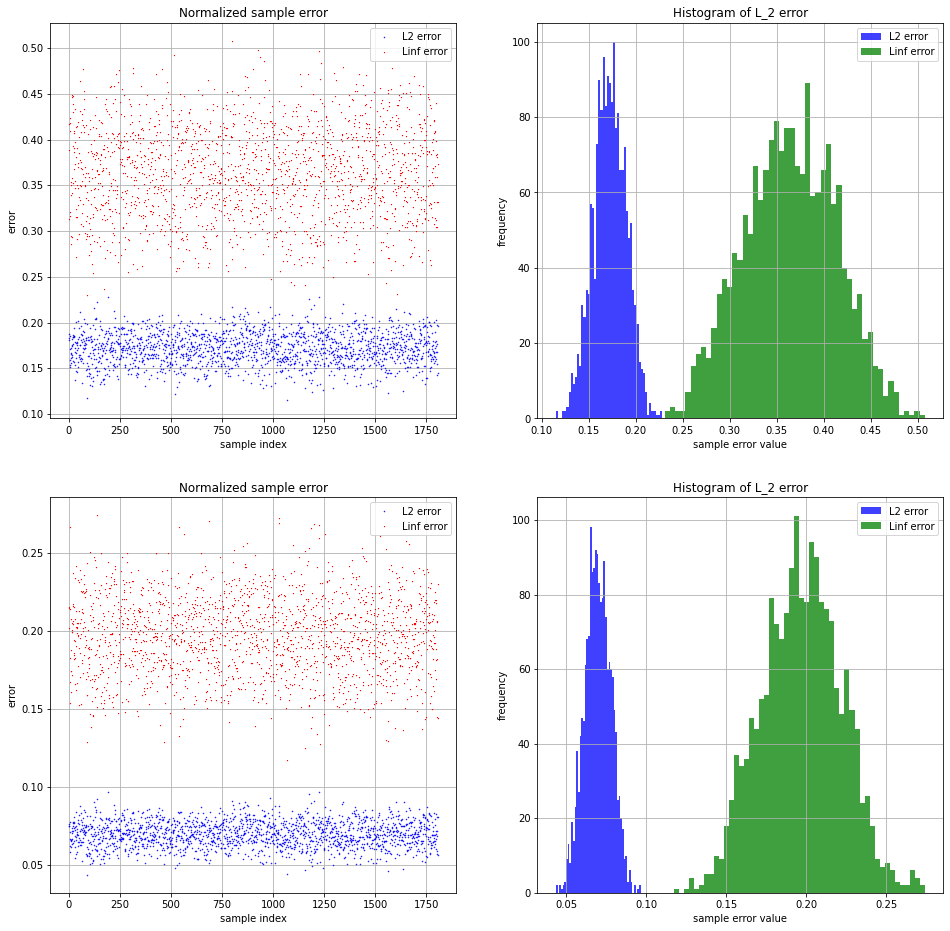

In [70]:
err_L2_mean = np.mean(err_L2)
err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
err_L2_mean_v = np.mean(err_L2_v)
err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )

fig2 = plt.figure(figsize=(16, 16))
plt.subplot(2, 2, 1)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 2)
plt.hist(err_L2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)

plt.subplot(2, 2, 3)
# plt.hist(np.abs(ga),bins = 10)
plt.plot(err_L2_v,'bo',markersize=0.5,label = 'L2 error')
plt.plot(err_Linf_v,'r^',markersize=0.5,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample index')
plt.ylabel('error')
plt.title('Normalized sample error')
plt.grid(True)
# error histogram
plt.subplot(2, 2, 4)
plt.hist(err_L2_v, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
plt.hist(err_Linf_v, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)

plt.show()

(1354, 1807) (1354, 1807)
true range: 2.0591 0.82781
predicted range 1.7193001708984377 0.7282605743408204


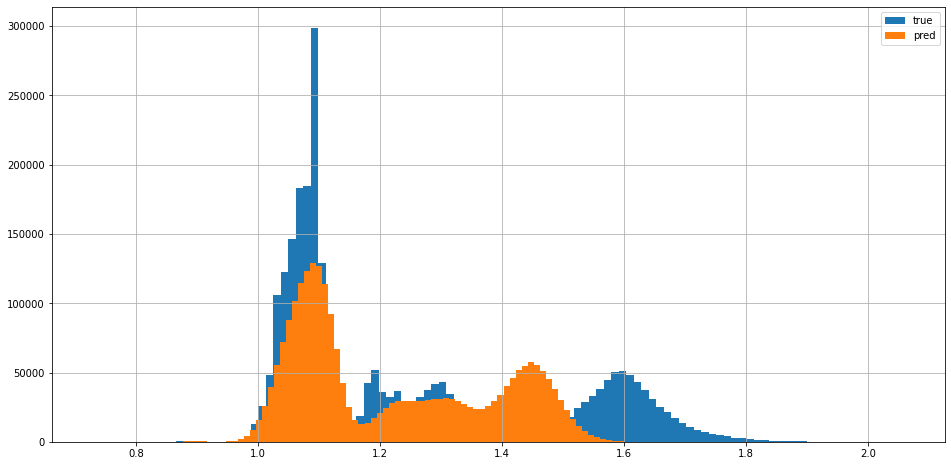

In [72]:
print(y_pred1[:,1,:n_test].shape,y_test2[:,1,:n_test].shape)
print('true range:',np.max(y_test2[:,1,:n_test]),np.min(y_test2[:,1,:n_test]))
print('predicted range',np.max(y_pred1[:,1,:n_test]),np.min(y_pred1[:,1,:n_test]))

fig3 = plt.figure(figsize=(16, 8))
flat_list1 = list(np.concatenate(y_test2[:,1,:n_test]).flat)
flat_list2 = list(np.concatenate(y_pred1[:,1,:n_test]).flat)
plt.hist(flat_list1,bins = 100,label = 'true')

plt.hist(flat_list2,bins = 100,label = 'pred')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [74]:
print(x_train.shape)
# print(x_train[:,:,1].transpose())
# print(np.max(gen_limit0),np.min(err_linf_new))

(6501, 8124)


In [85]:
print(x.shape,n_sample)

x_new = np.zeros([x_pre.shape[0],x_pre.shape[1],n_sample])
for i in range(x_pre.shape[1]):
  x_new[:,i,:] = x[n_bus*i:n_bus*(i+1),:]

y_new = np.zeros([y_pre.shape[0],y_pre.shape[1],n_sample])
for i in range(y_pre.shape[1]):
  y_new[:,i,:] = y[n_bus*i:n_bus*(i+1),:]

(8124, 9031) 9031


# Predict generation using $\pi$
* Using predicted $\pi$ and find the active constraints in $p_G(i)$
* For inactive $p_G(i)$ consider other methods like power flow balance

In [86]:
gen_limit0 = x_new[:,4,:].copy() # lin cost
print(gen_limit0.shape)

gen_idx = []
gen_idx = np.arange(n_bus)
# for i in range(n_bus):
#   if gen_limit0[i,0] > 0:
#     gen_idx.append(i)
print(type(gen_idx),len(gen_idx),gen_idx)

(1354, 9031)
<class 'numpy.ndarray'> 1354 [   0    1    2 ... 1351 1352 1353]


In [87]:
# # get the generator index
# # generator cost data
# gen_cost0
# # generator limit data
# gen_limit0
# # LMP data
# lmp_data
# # generation data
# gen_data

load_data = x.copy()
load_data = load_data[:,:]
print(load_data.shape)
n_sample = np.size(load_data,1)

# predict the corredponding LMP
x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
batch_size=2000
y_pred1=[]
with torch.no_grad():
  for idx in range(0,x_val_feed.shape[0],batch_size):
    current_batch=x_val_feed[idx:idx+batch_size]
    current_batch=current_batch.to(device)
    current_y=net(current_batch)
    current_y=current_y.cpu().detach()
    current_y=torch.squeeze(current_y,1).numpy().tolist()
    y_pred1+=current_y
y_pred1=np.array(y_pred1).transpose()

print('Dataset size:',x_val_feed.shape)
print('Number of validation points:: ',n_sample)

# net1 = net.cpu()
# y_pred = net1(x_val_feed)

# y_pred1 = y_pred.cpu().detach()
print('output size',y_pred1.shape)
# y_pred1 = torch.squ[]eeze(y_pred1,1).numpy().transpose()
print('reshaped size',y_pred1.shape)

# load_data = x.copy()
# print(load_data.shape)
# n_sample = np.size(load_data,2)

# x_val_feed = torch.from_numpy(np.transpose(load_data)).float()
# x_val_feed = x_val_feed.to(device)

# print('Dataset size:',x_val_feed.shape)
# print('Number of validation points:: ',n_sample)
# y_pred = net(x_val_feed) # predict the corredponding LMP

# y_pred1 = y_pred.cpu().detach()
# print('output size',y_pred1.shape)
# y_pred1 = torch.squeeze(y_pred1,1).numpy().transpose()
# print('reshaped size',y_pred1.shape)

(8124, 9031)
Dataset size: torch.Size([9031, 8124])
Number of validation points::  9031
output size (2708, 9031)
reshaped size (2708, 9031)


* Save results

In [88]:
import pickle

In [89]:
# dataset = {'lmp_pred': y_pred1, 'lmp_true': lmp_data}
# print('Pred:',y_pred1.shape,'True:',lmp_data.shape)

# file_name = 'dc118_lmp_prediction_p10'
# file_path = 'drive/My Drive/gnn/data/results/'
# file_dir = file_path + file_name + '.pickle'
# outfile = open(file_dir, 'wb')
# pickle.dump(dataset, outfile)
# outfile.close()

In [93]:
y_pred_temp = y_pred1.copy()
# y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
y_pred2=np.zeros([y_pre.shape[0],y_pre.shape[1],n_sample])
y_pred2[:,0,:]=y_pred_temp[:n_bus,:]
y_pred2[:,1,:]=y_pred_temp[n_bus:,:]
print(y_pred2.shape,y_pred1.shape)

y_pred1 = y_pred2.copy()

# y_test_temp = y_test.copy().transpose()
# # y_pred2=np.reshape(y_pred2,(y_pre.shape[0],y_pre.shape[1],n_test))
# y_test2=np.zeros([y_pre.shape[0],y_pre.shape[1],n_test])
# y_test2[:,0,:]=y_test_temp[:n_bus,:]
# y_test2[:,1,:]=y_test_temp[n_bus:,:]


(1354, 2, 9031) (2708, 9031)


In [94]:
gen_cost0 = x_new[:,4,:].copy()
lmp_data = y_new[:,0,:].copy()

quadratic_a = x_new[:,5,:].copy()

profit_pred = y_pred1[:,0,:] - gen_cost0
print(np.min(np.abs(profit_pred)))

profit_true = lmp_data - gen_cost0
print(np.min(np.abs(profit_true)))

profit_pred=(y_pred1[:,0,:]-gen_cost0)/(quadratic_a+1e-10)/2
profit_true=(lmp_data-gen_cost0)/(quadratic_a+1e-10)/2
print(np.min(np.abs(profit_pred)))
print(np.min(np.abs(profit_true)))

0.03065185546876137
0.009999999999990905
1.9171698505296003e-05
4.395990856359622e-06


(1354, 9031) (1354, 9031)
0.15121792619908397


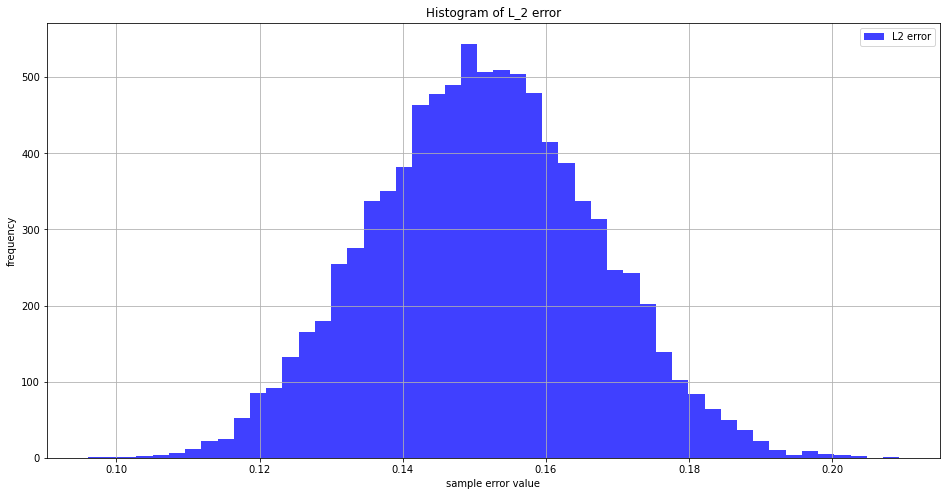

In [95]:
print(profit_pred.shape,profit_true.shape)
profit_err = profit_true - profit_pred

profit_err_l2 = np.zeros([n_sample,1])

for i in range(n_sample):
  profit_err_l2[i] = np.linalg.norm(profit_err[:,i])/np.linalg.norm(profit_true[:,i])
print(np.mean(profit_err_l2))

fig5 = plt.figure(figsize=(16, 8))
# error histogram
plt.hist(profit_err_l2, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [96]:
p_pred_sort = np.reshape(profit_pred,n_bus*n_sample)
p_true_sort = np.reshape(profit_true,n_bus*n_sample)
print(p_pred_sort.shape)

(12227974,)


In [97]:
print(np.min(p_pred_sort),np.min(p_true_sort))

-26191411621093.746 -26039000000000.0


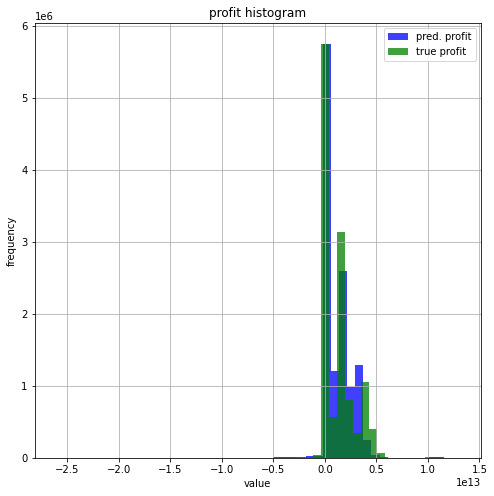

In [98]:
fig2 = plt.figure(figsize=(8, 8))
plt.hist(p_pred_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. profit')
plt.hist(p_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true profit')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('profit histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [99]:
# gen_pred_binary = np.zeros((len(gen_idx),n_sample))
# gen_true_binary = np.zeros((len(gen_idx),n_sample))
# print(gen_pred_binary.shape)

# binary_thres = 2.5
# binary_thres_true = 1e-5

# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres:
#       gen_pred_binary[j,i] = 1
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary[j,i] = 0
#     else:
#       # gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i] + binary_thres) / (2*binary_thres)
#       gen_pred_binary[j,i] = (profit_pred[gen_idx[j],i]) / (binary_thres)
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres_true:
#       gen_true_binary[j,i] = 1
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary[j,i] = 0
#     else:
#       gen_true_binary[j,i] = 0.5

# gen_binary_err = np.abs(gen_true_binary - gen_pred_binary)
# print('max binary error:',np.max(gen_binary_err))
# # count the wrong entries
# gen_binary_err_ct = np.sum(gen_binary_err)
# gen_binary_err_ratio = gen_binary_err_ct / (len(gen_idx)*n_sample)
# print('Binary accuracy:',1-gen_binary_err_ratio)

In [100]:
print(gen_limit0.shape)
print(np.transpose(x_test).shape,np.transpose(load_data).shape)

(1354, 9031)
(8124, 1807) (9031, 8124)


 # Test flow feasibility

In [101]:
x_new[:,2,:].shape
profit_pred.shape
# n_sample

(1354, 9031)

In [103]:
# x = [load, gen_cost, gen_lim]

# binary_thres = 0.97
binary_thres_true = 1e-5
# binary_thres = gen_limit0
binary_thres = x_new[:,0,:].copy() # upper
binary_thres_lo = x_new[:,1,:].copy() # lower

gen_pred_binary_full = np.zeros((n_bus,n_sample))
gen_true_binary_full = np.zeros((n_bus,n_sample))
# print(gen_pred_binary.shape,profit_pred.shape,gen_pred_binary_full.shape)

# x[:,2,:] # p_max

# ## generator injection
# for i in range(n_sample):
#   for j in range(len(gen_idx)):
#     # predicted generator limit
#     if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_pred[gen_idx[j],i] < 0:
#       gen_pred_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
#     # true generator limit
#     if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
#       gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
#     elif profit_true[gen_idx[j],i] < 0:
#       gen_true_binary_full[gen_idx[j],i] = 0
#     else:
#       gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]

## nodal injection
# gen_limit0 = x[:,2,:].copy()
for i in range(n_sample):
  for j in range(len(gen_idx)):
    # predicted generator limit
    if profit_pred[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_pred[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_pred_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_pred_binary_full[gen_idx[j],i] = profit_pred[gen_idx[j],i]
    # true generator limit
    if profit_true[gen_idx[j],i] > binary_thres[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres[gen_idx[j],i]
    elif profit_true[gen_idx[j],i] < binary_thres_lo[gen_idx[j],i]:
      gen_true_binary_full[gen_idx[j],i] = binary_thres_lo[gen_idx[j],i]
    else:
      gen_true_binary_full[gen_idx[j],i] = profit_true[gen_idx[j],i]


# injection by generators
# gen_inj = np.multiply(gen_pred_binary_full,gen_limit0)
# gen_inj_true = np.multiply(gen_true_binary_full,gen_limit0)
gen_inj=gen_pred_binary_full
gen_inj_true=gen_true_binary_full
# nodal injection
load0 = -x_new[:,1,:].copy() # load file
p_inj = gen_inj #- load0
p_inj_true = gen_inj_true #- load0

In [104]:
# load0 = x[:,0,:].copy()
print(np.sum(p_inj),np.sum(gen_inj_true))
print(np.sum(p_inj),np.sum(load0),np.sum(gen_inj))

136339837.77891707 137407249.71374837
136339837.77891707 -279772512.7095772 136339837.77891707


## injection accuracy

(1354, 9031) (1354, 9031)
mean p_inj l2 err: 0.015407810242886167


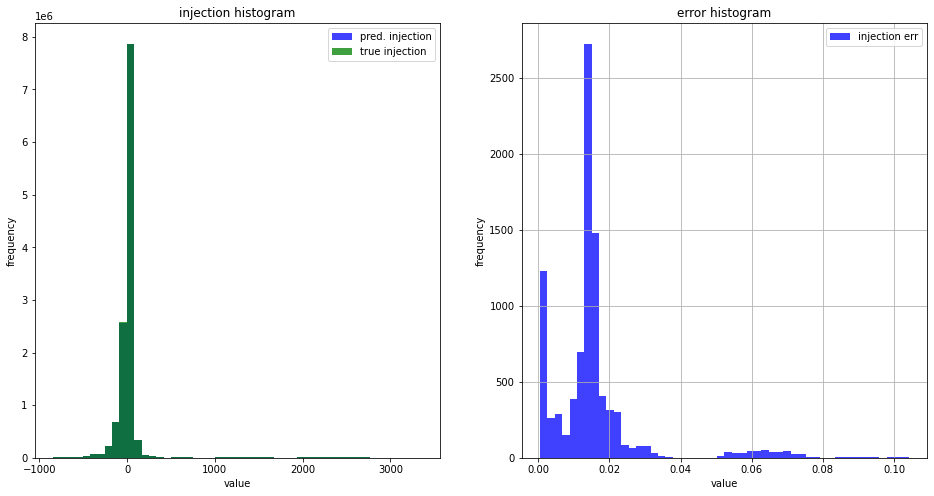

In [105]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
fig3 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('injection histogram')
plt.subplot(1,2,2)
plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('error histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

* Calculate flow

In [106]:
filename=root+'data_1354ac_2022/ieee1354_fmax.txt'
f_max1=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit

n_line = np.size(S_isf,0)
flow_est = np.zeros((n_line,n_sample))
flow_est0 = np.zeros((n_line,n_sample))

f_binary = np.zeros((n_line,n_sample))
f_binary0 = np.zeros((n_line,n_sample))

# for i in range(n_sample):
flow_est = np.dot(S_isf,p_inj)
flow_est0 = np.dot(S_isf,p_inj_true)
# f_max
# f_max_numpy = f_max.cpu().detach().numpy()
f_max_numpy = f_max1.copy()
f_binary = (np.abs(flow_est)-f_max_numpy > 0)
f_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)

In [107]:
print(f_max_numpy.shape,flow_est.shape,flow_est0.shape)

(1991, 1) (1991, 9031) (1991, 9031)


In [108]:
f_tot_sample = n_line * n_sample
print(np.sum(f_binary),np.sum(f_binary0))
print(np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)

1053961 1053278
0.05861617006348077 0.05857818493485328


In [109]:
print(n_line,n_sample,flow_est.shape)

1991 9031 (1991, 9031)


In [110]:
# soft threshold
f_err_est = np.abs(flow_est)-f_max_numpy
f_err_true = np.abs(flow_est0)-f_max_numpy

f_err_est = np.maximum(np.abs(flow_est)-f_max_numpy,0) # identify violations
f_err_true = np.maximum(np.abs(flow_est0)-f_max_numpy,0)

print(np.max(f_err_est),np.max(f_err_true))
print(np.max(f_err_est/f_max_numpy),np.max(f_err_true/f_max_numpy))

# a= np.asarray([[1,2,1],[2,2,1]])
# b = np.asarray([1,1,1])
# c = (a-b>0)
# print(c)
# print(np.sum(c))

2093.0472804024803 2093.09275556404
5.566615107453405 5.566736052032022


In [111]:
np.min(f_max_numpy)

281.0

In [112]:
# f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.01*np.max(f_max_numpy))
# f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.01*np.max(f_max_numpy))
f_binary_soft = (np.abs(flow_est)-f_max_numpy > 0.1*(f_max_numpy))
f_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(f_binary_soft),np.sum(f_binary0_soft))
print(np.sum(f_binary_soft)/f_tot_sample,np.sum(f_binary0_soft)/f_tot_sample)

904027 902968
0.050277572295349 0.05021867588068354


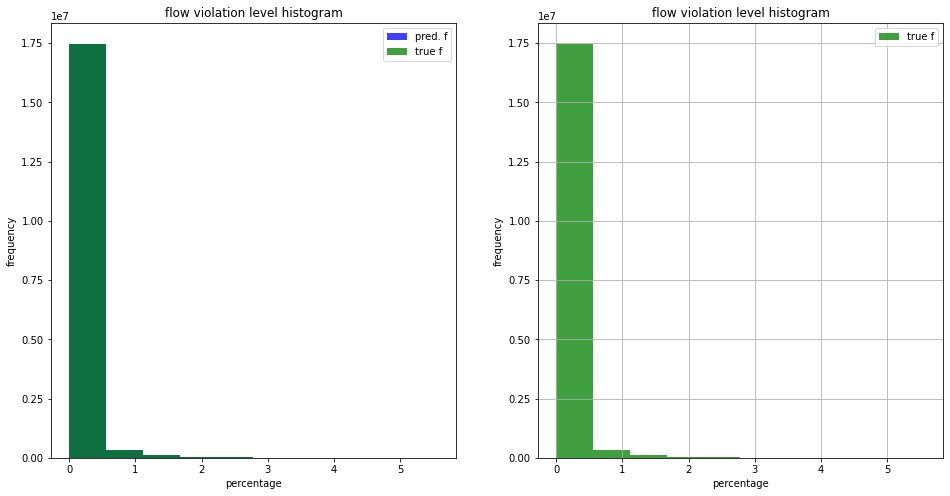

In [113]:
f_pred_sort = np.reshape(f_err_est/f_max_numpy,n_line*n_sample)
f_true_sort = np.reshape(f_err_true/f_max_numpy,n_line*n_sample)

fig2 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(f_pred_sort, bins = 10, facecolor='b', alpha=0.75,label = 'pred. f')
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
plt.subplot(1,2,2)
plt.hist(f_true_sort, bins = 10, facecolor='g', alpha=0.75,label = 'true f')
plt.legend(loc="upper right")
plt.xlabel('percentage')
plt.ylabel('frequency')
plt.title('flow violation level histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [114]:
f_line = np.sum(f_binary,0)
f_samp = np.sum(f_binary,1)
print('max sample pred:',np.max(f_line))
print('max line pred:',np.max(f_samp))

f_line0  = np.sum(f_binary0,0)
f_samp0 = np.sum(f_binary0,1)
print('max sample true:',np.max(f_line0))
print('max line true:',np.max(f_samp0))

max sample pred: 141
max line pred: 9031
max sample true: 141
max line true: 9031


# Check objective optimality

In [115]:
# gen_pred_binary_full = np.zeros((n_bus,n_sample))
# gen_true_binary_full = np.zeros((n_bus,n_sample))

# p_inj = gen_inj #- load0
# p_inj_true = gen_inj_true #- load0

# gen_cost0 = x[:,4,:].copy()
# # lmp_data = y.copy()

# quadratic_a = x[:,5,:].copy()
print(gen_cost0.shape)

(1354, 9031)


-0.0003462080356925817


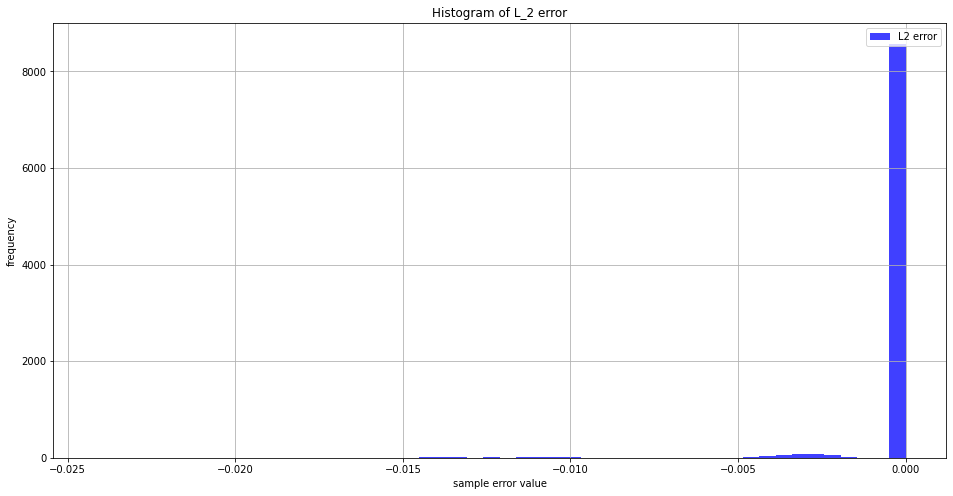

In [116]:
gen_cost_pred = np.zeros((n_bus,n_sample))
gen_cost_true = np.zeros((n_bus,n_sample))
objective_err = np.zeros(n_sample)

gen_cost_pred = np.multiply(np.multiply(p_inj,p_inj),quadratic_a) + np.multiply(p_inj,gen_cost0)
gen_cost_true = np.multiply(np.multiply(p_inj_true,p_inj_true),quadratic_a) + np.multiply(p_inj_true,gen_cost0)

objective_err = np.sum(np.abs(gen_cost_true-gen_cost_pred),axis=0) / np.sum(gen_cost_true,axis=0)
print(np.mean(objective_err))

fig6 = plt.figure(figsize=(16, 8))
# error histogram
plt.hist(objective_err, bins = 50, facecolor='b', alpha=0.75,label = 'L2 error')
# plt.hist(err_linf_new, bins = 50, facecolor='g', alpha=0.75,label = 'Linf error')
plt.legend(loc="upper right")
plt.xlabel('sample error value')
plt.ylabel('frequency')
plt.title('Histogram of L_2 error')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

In [117]:
objective_err.shape

(9031,)

## injection accuracy

(1354, 9031) (1354, 9031)
mean p_inj l2 err: 0.015407810242886167


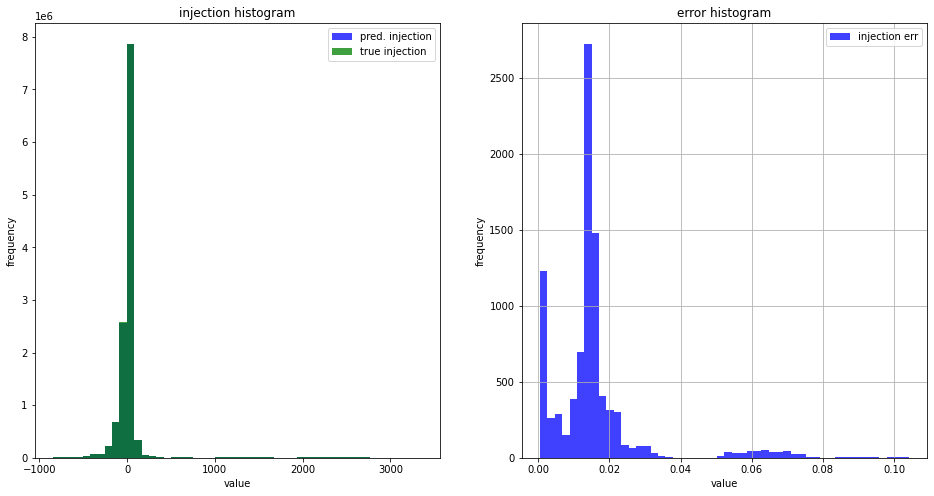

In [118]:
print(p_inj_true.shape,p_inj.shape)

p_inj_true_sort = np.reshape(p_inj_true,n_bus*n_sample)
p_inj_sort = np.reshape(p_inj,n_bus*n_sample)

p_err = np.zeros(n_sample)
for i in range(n_sample):
  p_err[i] = np.linalg.norm(p_inj_true[:,i]-p_inj[:,i]) / np.linalg.norm(p_inj_true[:,i])

print('mean p_inj l2 err:',np.mean(p_err))
fig3 = plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.hist(p_inj_sort, bins = 50, facecolor='b', alpha=0.75,label = 'pred. injection')
plt.hist(p_inj_true_sort, bins = 50, facecolor='g', alpha=0.75,label = 'true injection')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('injection histogram')
plt.subplot(1,2,2)
plt.hist(p_err, bins = 50, facecolor='b', alpha=0.75,label = 'injection err')
plt.legend(loc="upper right")
plt.xlabel('value')
plt.ylabel('frequency')
plt.title('error histogram')
# plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.grid(True)
plt.show()

# Test AC feasibility
* P in actual value, V in p.u.
* Use P to recover $\theta$, or solve $\theta$ and Q for PF
$$ Q_m = V_m \sum_{n=1}^N V_n \left(G_{mn}\sin\theta_{mn} - B_{mn}\cos\theta_{mn} \right) $$
calculate $Q_{mn}$ directly

In [119]:
# p_inj (base all 100), p=B\theta, \theta_r = B_r^-1 p_r, ref bus is 69


In [120]:
# Bbus and B_r inverse
filename1 = root+'data_1354ac_2022/ieee1354_Bbus.txt'
Bbus=pd.read_table(filename1,sep=',',header=None).to_numpy()
B_r = np.delete(Bbus,639,axis=0)
B_r = np.delete(B_r,639,axis=1)

Br_inv = np.linalg.inv(B_r)

# Jacobian for fast decoupled power flow 
filename1 = root+'data_1354ac_2022/ieee1354_ieee1354_J1.txt'
J1=pd.read_table(filename1,sep=',',header=None).to_numpy()
# J1_r = np.delete(J1,639,axis=0) # already reduced
# J1_r = np.delete(J1_r,639,axis=1)
J1r_inv = np.linalg.inv(J1)

# nominal angle for fast decoupled power flow 
filename1 = root+'data_1354ac_2022/ieee1354_ieee1354_theta_nominal.txt'
theta_nominal=pd.read_table(filename1,sep=',',header=None).to_numpy()
# nominal injection for fast decoupled power flow 
filename1 = root+'data_1354ac_2022/ieee1354_ieee1354_pinj_nominal.txt'
pinj_nominal=pd.read_table(filename1,sep=',',header=None).to_numpy()


# line parameters
filename1 = root+'data_1354ac_2022/ieee1354_lineloc.txt'
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()
# line_entry_loc = np.nonzero(G_mat) # index of nonzero entries
# # not in p.u.
# G_line = np.zeros(n_line)
# B_line = np.zeros(n_line)

# # print(line_loc.shape) #[186,2]
# for i in range(n_line):
#   G_line[i] = G_mat[line_loc[i,0]-1,line_loc[i,1]-1]
#   B_line[i] = B_mat[line_loc[i,0]-1,line_loc[i,1]-1]

# load line params
filename1 = root+'data_1354ac_2022/ieee1354_lineparams_tap.txt'
line_params = pd.read_table(filename1,sep=',',header=None).to_numpy()

n_line = 1751 # the rest are transformers
line_loc = line_loc[:n_line,:].copy()
line_params = line_params[:n_line,:].copy()

# filename2 = 'data_1354ac_2022/ieee1354_Ybus.txt'
# Y_bus = pd.read_table(filename2,sep=',',header=None).to_numpy()

# G_line = line_params[:,0].copy()
# B_line = line_params[:,1].copy()
R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()

B_shunt = line_params[:,2].copy()

Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line

G_line = np.real(Y_line)
B_line = np.imag(Y_line)

# transformer indicator
# a = R_line > 0
a = np.ones(n_line)
a=torch.from_numpy(a)
G_line=torch.from_numpy(G_line)
B_line=torch.from_numpy(B_line)
B_shunt=torch.from_numpy(B_shunt)

# P_inj w/out reference bus in p.u.
p_inj_r = np.delete(p_inj,639,axis=0) / 100
p_inj_true_r = np.delete(p_inj_true,639,axis=0) / 100

p_inj_pu = p_inj / 100
p_inj_true_pu = p_inj_true / 100

# print(Br_inv.shape,p_inj.shape,p_inj_true.shape)#p_inj_true
print(J1r_inv.shape,p_inj.shape,p_inj_true.shape)
print(J1r_inv.shape,p_inj_r.shape,pinj_nominal.shape)

# calculate angle (w/our reference at 640th node)
# theta0 = np.matmul(Br_inv,p_inj_r)
# theta_true0 = np.matmul(Br_inv,p_inj_true_r)
theta0 = np.matmul(J1r_inv,p_inj_r-pinj_nominal)
theta_true0 = np.matmul(J1r_inv,p_inj_true_r-pinj_nominal)

theta = np.insert(theta0,639,0,axis = 0)
theta_true = np.insert(theta_true0,639,0,axis = 0)
# restore from deviation
theta = theta + theta_nominal/180*math.pi
theta_true = theta_true + theta_nominal/180*math.pi

# filename1 = '/content/drive/MyDrive/gnn/data/data_118_quad/ieee118_ac_10000_theta.txt'
# theta = pd.read_table(filename1,sep=',',header=None).to_numpy()
# theta = theta / 180 * math.pi

print(theta.shape,theta_true.shape)

(1353, 1353) (1354, 9031) (1354, 9031)
(1353, 1353) (1353, 9031) (1353, 1)
(1354, 9031) (1354, 9031)


In [121]:
# print(theta_true0)
# print('deviation')
# print(theta0-theta_true0)
print(np.matmul(J1r_inv,p_inj_r-pinj_nominal))

[[0.2340249  0.23992069 0.3030898  ... 0.45324941 0.21203967 0.35860941]
 [0.50998994 0.51081117 0.54822387 ... 0.62586679 0.49582025 0.5659571 ]
 [1.35221586 1.37474747 1.46860318 ... 1.67529308 1.33872842 1.52153882]
 ...
 [2.4485859  2.51365884 2.61698691 ... 2.829311   2.41918204 2.62685866]
 [1.02735756 1.05820838 1.12789529 ... 1.31994291 1.02435647 1.1706481 ]
 [0.71550446 0.7830508  0.83863114 ... 1.0599659  0.69801571 0.91251334]]


In [122]:
for i in range(5):
  print(G_line[i],B_line[i])

tensor(280.2163, dtype=torch.float64) tensor(-1215.8272, dtype=torch.float64)
tensor(10.3055, dtype=torch.float64) tensor(-58.0878, dtype=torch.float64)
tensor(29.5110, dtype=torch.float64) tensor(-227.6560, dtype=torch.float64)
tensor(32.8321, dtype=torch.float64) tensor(-403.8348, dtype=torch.float64)
tensor(20.9748, dtype=torch.float64) tensor(-263.5829, dtype=torch.float64)


In [123]:
print(np.max(theta),np.min(theta))
# math.sin(math.pi/6)
print(G_line[0],B_line[0])


# print(Y_bus.shape,line_loc.shape,G_line.shape,n_line)

# G_line1 = np.zeros(n_line)
# B_line1 = np.zeros(n_line)

# for i in range(2):
#   Y_temp = Y_bus[line_loc[i,0]-1,line_loc[i,1]-1]
#   Y_temp = Y_temp.replace('i','j')
#   Y_temp = complex(Y_temp)
#   # print(type(Y_temp))
#   # print(Y_temp,np.real(Y_temp),np.imag(Y_temp))
#   G_line1[i] = np.real(Y_temp)
#   B_line1[i] = np.imag(Y_temp)

# G_line = G_line1
# B_line = B_line1

3.5340584450403325 -0.39550272070301284
tensor(280.2163, dtype=torch.float64) tensor(-1215.8272, dtype=torch.float64)


In [124]:
print(type(G_line))
print(np.max(y_pred1[:,1,:]),np.min(y_pred1[:,1,:]))
print(np.max(theta),np.min(theta))
print(math.sin(math.pi/6))

<class 'torch.Tensor'>
926.4141235351562 -76.99308776855469
3.5340584450403325 -0.39550272070301284
0.49999999999999994


In [125]:
# B_line
import math

# n_sample1 = 500
n_sample1 = n_sample
f_tot_sample1 = n_line*n_sample1

# load true voltage file
filename1 = root+'data_1354ac_2022/ieee1354pegase_ac_9974_cases_v_04022022.txt'
v_true = pd.read_table(filename1,sep=',',header=None).to_numpy()
print(v_true.shape)

# load true theta file
filename2 = root+'data_1354ac_2022/ieee1354pegase_ac_9974_cases_theta_04022022.txt'
theta_true = pd.read_table(filename2,sep=',',header=None).to_numpy()
# theta_true = theta_true / 180 * math.pi
print(theta_true)
print(theta_true.shape)

v_true = np.delete(v_true, del_idx,axis=1)
theta_true = np.delete(theta_true, del_idx,axis=1)
print(v_true.shape,theta_true.shape)

(1354, 9974)
[[-19.085   -19.996   -17.394   ... -17.016   -18.041   -18.042  ]
 [ -1.5689   -1.689    -1.0069  ...  -0.33903  -0.99374  -2.4735 ]
 [-44.41    -44.106   -43.909   ... -44.498   -43.883   -44.796  ]
 ...
 [-31.162   -25.654   -26.204   ... -26.987   -27.145   -29.515  ]
 [-35.832   -34.86    -35.009   ... -35.492   -35.535   -35.59   ]
 [-26.664   -28.941   -28.263   ... -28.603   -28.076   -29.286  ]]
(1354, 9974)
(1354, 9031) (1354, 9031)


In [126]:
v_true.shape

(1354, 9031)

In [127]:
# print(theta)
# print('')
# print(theta_true)
v_pred = y_pred1[:,1,:].copy()
v_pred = v_pred / vy_scale + vy_deviation
print(v_pred)
print('')
print(v_true)

[[1.28015839 1.28923157 1.32332947 ... 1.24777182 1.24487482 1.28394177]
 [1.09827609 1.12709528 1.1232417  ... 1.09838855 1.13591595 1.07491425]
 [1.23394003 1.23511023 1.25640051 ... 1.19683951 1.23042789 1.2123158 ]
 ...
 [1.07127155 1.0585592  1.14159222 ... 1.0857041  1.08433881 1.0759238 ]
 [1.45810333 1.52659094 1.50036945 ... 1.45260492 1.4717251  1.42799304]
 [1.08132941 1.10592532 1.12315326 ... 1.06352719 1.08713495 1.09750717]]

[[1.0692 1.0699 1.0721 ... 1.0775 1.0751 1.0734]
 [1.0702 1.0707 1.0696 ... 1.071  1.0713 1.0716]
 [1.0707 1.0625 1.0666 ... 1.0694 1.07   1.0716]
 ...
 [1.0847 1.084  1.0788 ... 1.0595 1.0699 1.0705]
 [1.0537 1.0556 1.0558 ... 1.0567 1.0557 1.0581]
 [1.0786 1.0571 1.0616 ... 1.0613 1.0684 1.0854]]


In [128]:


# Calculate real and reactive flow
f_p = np.zeros((n_line,n_sample1))
f_q = np.zeros((n_line,n_sample1))
fji_p = np.zeros((n_line,n_sample1))
fji_q = np.zeros((n_line,n_sample1))
print(f_q.shape)

v_pred = y_pred1[:,1,:].copy()
v_pred = v_pred / vy_scale + vy_deviation

# v_pred = v_true.copy()
# theta = theta_true.copy()

print(np.max(v_pred),np.min(v_pred),v_pred.shape)

theta1 = theta[line_loc[:,0]-1,:]
theta2 = theta[line_loc[:,1]-1,:]
V1 = torch.from_numpy(v_pred[line_loc[:,0]-1,:]).double()
V2 = torch.from_numpy(v_pred[line_loc[:,1]-1,:]).double() 
theta1=torch.from_numpy(theta1)
theta2=torch.from_numpy(theta2)

f_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*torch.cos(theta1-theta2).T+B_line*torch.sin(theta1-theta2).T)
f_p=f_p.T
f_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*torch.cos(theta1-theta2).T-G_line*torch.sin(theta1-theta2).T)
f_q=f_q.T

theta1 = theta[line_loc[:,1]-1,:]
theta2 = theta[line_loc[:,0]-1,:]
V1 = torch.from_numpy(v_pred[line_loc[:,1]-1,:]).double()
V2 = torch.from_numpy(v_pred[line_loc[:,0]-1,:]).double()
theta1=torch.from_numpy(theta1)
theta2=torch.from_numpy(theta2)

fji_p=(a*G_line*(V1*V1).T)-a*((V1*V2).T)*(G_line*torch.cos(theta1-theta2).T+B_line*torch.sin(theta1-theta2).T)
fji_p=fji_p.T
fji_q=-a*(V1.T)*(a*V1.T)*(B_line+B_shunt/2)+a*((V1*V2).T)*(B_line*torch.cos(theta1-theta2).T-G_line*torch.sin(theta1-theta2).T)
fji_q=fji_q.T

# for i in range(n_line):
#   for j in range(n_sample1):
#     f_p[i,j] = a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i] \
#              - (a[i] * v_pred[line_loc[i,0]-1,j]) * v_pred[line_loc[i,1]-1,j] \
#              * (G_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
#               + B_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
#     f_q[i,j] =-(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
#              + a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,1]-1,j] \
#              * (B_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
#               - G_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
#     fji_p[i,j] = a[i] * v_pred[line_loc[i,1]-1,j] * v_pred[line_loc[i,1]-1,j] * G_line[i] \
#              - (a[i] * v_pred[line_loc[i,1]-1,j]) * v_pred[line_loc[i,0]-1,j] \
#              * (G_line[i] * math.cos(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]) \
#               + B_line[i] * math.sin(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]))
#     fji_q[i,j] =-(a[i] * v_pred[line_loc[i,1]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
#              + a[i] * v_pred[line_loc[i,1]-1,j] * v_pred[line_loc[i,0]-1,j] \
#              * (B_line[i] * math.cos(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]) \
#               - G_line[i] * math.sin(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]))         


(1751, 9031)
1.7264141235351564 0.7230069122314453 (1354, 9031)


In [129]:
print('mean p_ij,q_ij:',torch.mean(f_p),torch.mean(f_q))
print('mean p_ji,q_ji:',torch.mean(fji_p),torch.mean(fji_q))
# print(f_q)

mean p_ij,q_ij: tensor(3.3412, dtype=torch.float64) tensor(12.9077, dtype=torch.float64)
mean p_ji,q_ji: tensor(0.8342, dtype=torch.float64) tensor(7.3351, dtype=torch.float64)


In [130]:
theta = theta_true.copy()
print('Scale check:')
i=0;j=0
# a[0] = 1
a = np.ones(1751)
print('G,B,loc:',G_line[i],B_line[i],line_loc[i,0]-1,line_loc[i,1]-1) # G,B,line_loc verified
print('v:',v_pred[line_loc[i,0]-1,j],v_pred[line_loc[i,1]-1,j]) # v verified
print('theta:',theta[line_loc[i,0]-1,j],theta[line_loc[i,1]-1,j]) # theta verified
print('p,q:',f_p[0,0],f_q[0,0],fji_p[i,j],fji_q[i,j])


f_p_test = a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i] \
             - (a[i] * v_pred[line_loc[i,0]-1,j]) * v_pred[line_loc[i,1]-1,j] \
             * (G_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              + B_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
f_q_test =-(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
             + a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,1]-1,j] \
             * (B_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              - G_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
print('test p/q:',f_p_test,f_q_test)

Scale check:
G,B,loc: tensor(280.2163, dtype=torch.float64) tensor(-1215.8272, dtype=torch.float64) 1073 801
v: 1.0645622253417968 1.1121473388671874
theta: -19.014 -18.995
p,q: tensor(-14.0176, dtype=torch.float64) tensor(-61.6314, dtype=torch.float64) tensor(14.6521, dtype=torch.float64) tensor(64.3845, dtype=torch.float64)
test p/q: tensor(-41.4836, dtype=torch.float64) tensor(-55.0276, dtype=torch.float64)


In [131]:
print(a[i],v_pred[line_loc[i,0]-1,j],B_line[i] + B_shunt[i]/2,v_pred[line_loc[i,1]-1,j])
print(G_line[i],math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]),math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))

1.0 1.0645622253417968 tensor(-1215.8272, dtype=torch.float64) 1.1121473388671874
tensor(280.2163, dtype=torch.float64) 0.9998195054299763 -0.018998856853965667


In [132]:
# Calculate apparent power
# s_pred = np.zeros((n_line,n_sample1))
# sji_pred = np.zeros((n_line,n_sample1))

# for i in range(n_line):
#   for j in range(n_sample1):
#     # s_pred[i,j] = np.sqrt(flow_est[i,j]**2 + f_q[i,j]**2)
#     s_pred[i,j] = np.sqrt(f_p[i,j]**2 + f_q[i,j]**2)
#     sji_pred[i,j] = np.sqrt(fji_p[i,j]**2 + fji_q[i,j]**2)

s_pred = torch.sqrt(f_p*f_p+f_q*f_q)*100
sji_pred = torch.sqrt(fji_p*fji_p+fji_q*fji_q)*100
# s_pred = s_pred * 100 # p.u. to mva
# sji_pred = sji_pred * 100 # p.u. to mva

In [133]:
# np.max(y_pred1[:,1,:]/100+0.8)

f_p = f_p.numpy();f_q = f_q.numpy()
s_pred = s_pred.numpy();sji_pred = sji_pred.numpy()

print(np.max(f_q),np.min(f_q))
flow_est.shape

print(np.mean(s_pred[0,:]),np.mean(f_max_numpy[0]))

4246.412286850677 -3055.679571041227
6003.177491576912 39412.0


In [134]:
sij_binary = (np.abs(s_pred)-f_max_numpy[:n_line] > 0)
sji_binary = (np.abs(sji_pred)-f_max_numpy[:n_line] > 0)
s_binary = np.maximum(sij_binary,sji_binary)

# sij_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)
print(np.sum(s_binary))#,np.sum(f_binary0))
print('hard violation rate:',np.sum(s_binary)/f_tot_sample1)#,np.sum(f_binary0)/f_tot_sample)

s_binary_soft = (np.abs(s_pred)-f_max_numpy[:n_line] > 0.1*(f_max_numpy[:n_line]))
# s_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(s_binary_soft))#,np.sum(f_binary0_soft))
print(np.sum(s_binary_soft)/f_tot_sample1)#,np.sum(f_binary0_soft)/f_tot_sample)

10839443
hard violation rate: 0.6854645155549945
10124909
0.6402788263865038


S violation level:
hard: 0.6854645155549945
mean: 10.330555084056078
median: 0.8455563083699319
max: 1305.2185474257942
std: 40.57106405236776
p99: 192.87275141496656
f violation level:
hard: 0.05861617006348077 0.05857818493485328
mean: 0.041385447359853646
median: 0.0
max: 5.566615107453405
std: 0.24059829893232643
p99: 1.164154570098117


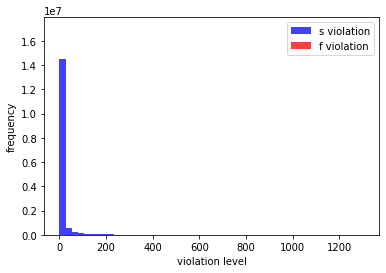

In [135]:
# violation level
sij_violation = np.abs(s_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sij_violation_level = np.maximum(sij_violation,0)
sji_violation = np.abs(sji_pred)-f_max_numpy[:n_line] #/ f_max_numpy
sji_violation_level = np.maximum(sji_violation,0)

s_violation_level = np.maximum(sij_violation_level,sji_violation_level)

s_violation_level = np.divide(s_violation_level,f_max_numpy[:n_line])
s_vio_lvl = np.reshape(s_violation_level,n_line*n_sample1)

print('S violation level:')
print('hard:',np.sum(s_binary)/f_tot_sample1)
print('mean:',np.mean(s_vio_lvl))
print('median:',np.median(s_vio_lvl))
print('max:',np.max(s_vio_lvl))
print('std:',np.std(s_vio_lvl))
print('p99:',np.percentile(s_vio_lvl,99))

f_violation = np.abs(flow_est)-f_max_numpy #/ f_max_numpy
f_violation_level = np.maximum(f_violation,0)
f_violation_level = np.divide(f_violation_level,f_max_numpy)
f_vio_lvl = np.reshape(f_violation_level,1991*n_sample)

print('f violation level:')
print('hard:',np.sum(f_binary)/f_tot_sample,np.sum(f_binary0)/f_tot_sample)
print('mean:',np.mean(f_vio_lvl))
print('median:',np.median(f_vio_lvl))
print('max:',np.max(f_vio_lvl))
print('std:',np.std(f_vio_lvl))
print('p99:',np.percentile(f_vio_lvl,99))

fig4 = plt.figure(figsize=(6,4))
plt.hist(s_vio_lvl, bins = 50, facecolor='b', alpha=0.75,label = 's violation')
plt.hist(f_vio_lvl, bins = 50, facecolor='r', alpha=0.75,label = 'f violation')
plt.legend(loc="upper right")
plt.xlabel('violation level')
plt.ylabel('frequency')
# plt.title('injection histogram')
plt.show()

In [136]:
# err_L2_mean = np.mean(err_L2)
# err_Linf_mean = np.mean(err_Linf)
print('Price L2 mean:', err_L2_mean,'L_inf mean:', err_Linf_mean )
print('std:',np.std(err_L2))
# err_L2_mean_v = np.mean(err_L2_v)
# err_Linf_mean_v = np.mean(err_Linf_v)
print('Voltage L2 mean:', err_L2_mean_v,'L_inf mean:', err_Linf_mean_v )
print('std:',np.std(err_L2_v))

Price L2 mean: 0.17218456223625575 L_inf mean: 0.3641907824652842
std: 0.01747545085410294
Voltage L2 mean: 0.06979595522697234 L_inf mean: 0.19695008927483865
std: 0.008257818336155194


In [ ]:
# np.max(s_violation_level)
# s_violation_level[:,0]
# print(s_pred[:,0])
# print(f_max_numpy)

In [ ]:
# # solve for Q
# from scipy.optimize import fsolve

# # print(np.max(theta*180/2/math.pi),np.max(theta_true*180/2/math.pi))

# def PF_eq(Q,V,G_mat,B_mat,n_bus,line_loc):
#   PF_obj = [None]*n_bus
#   for i in range(n_bus):
#     PF_obj[i] = 

#   return PF_obj

# line_loc = np.nonzero(G_mat) # index of nonzero entries
# root = fsolve(PF_eq, np.zeros(118, args=(y_pred1[:,1,:0],G_mat,B_mat,n_bus,line_loc))